Number of time steps:3592


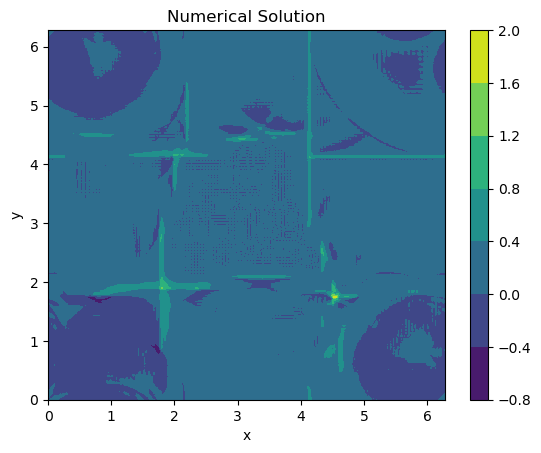

In [23]:
#Eric Gelphman
#Colorado School of Mines Department of Applied Mathematics and Statistics
#Ahmed Ahmed
#Colorado School of Mines Department of Geophysics
#Solution of 2D Wave Equation Over Domain of Heterogeneous Media Using the
#Fourier-Based Pseudospectral Method
#October 25, 2023

import numpy as np
import scipy.fftpack as sfft
import scipy.interpolate as interp
import matplotlib.pyplot as plt

PI = np.pi
eps_0 = 8.8541878176e-12 #Electrical permitivitty of free space
u_0 = 12.5663706144e-7 #Magnetic permeability of free space

def pointInPolygon(x,y,poly):
    """
    Function to determine if the point (x,y) lies inside the closed polygon poly, not including the boundary
    using Ray Tracing

    Parameters:
    x,y: xy-coordinates of point
    poly: K x 2 Numpy array of points (x,y) that form boundary of polygon, ordered clockwise or counterclockwise

    Return:
    True if (x,y) is inside poly, False otherwise
    """
    n = len(poly)
    inside = False
    p2x = 0.0
    p2y = 0.0
    xints = 0.0
    p1x = poly[0][0]
    p1y = poly[0][1]
    for i in np.arange(n+1):
        p2x = poly[i % n][0]
        p2y = poly[i % n][1]
        if y > min(p1y,p2y):
            if y <= max(p1y,p2y):
                if x <= max(p1x,p2x):
                    if p1y != p2y:
                        xints = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or x <= xints:
                        inside = not inside
        p1x,p1y = p2x,p2y
    return inside

def spectralLaplacian(Yk, ik1, ik2, c2):
    """
    Function to calculate the Laplacian u = Del*((c^2(x1,x2))Del(y(x1,x2))) in the Fourier domain
    where Del is the two-dimensional gradient operator using Algorithm 7 from the paper "Notes on 
    FFT Based Differentiation" by Stephen Johnson of MIT from May 2011. c^2(x1,x2) represents 
    the square of the wave speed at location (x1,x2)

    Parameters:
        Yk: Two-dimensional Fourier transform Y(k1,k2)
        ik1: i*Meshgrid of wave numbers for dimension 1 
        ik2: i*Meshgrid of wave numbers for dimension 2 
        c2: The function representing wave speed c^2(x1,x2)

    Return: 
        u: Spectral Laplacian u(x1,x2)
    """
    #Step 1 - Calculate Gradient of Yk in Frequency Domain
    gn1 = np.real(sfft.ifft2(ik1*Yk))
    gn2 = np.real(sfft.ifft2(ik2*Yk))
    #Step 2 - Inverse FFT to efficiently calculate c^2(x,y)*Del(Yk) in time domain
    vn1 = np.multiply(c2, gn1)
    vn2 = np.multiply(c2, gn2)
    #Step 3 - Calculate Del dot Del(Yk) in frequency domain to get spectral Laplacian
    Vk1 = sfft.fft2(vn1)
    Vk2 = sfft.fft2(vn2)
    Uk = (ik1*Vk1) + (ik2*Vk2)
    return Uk

def calcEpsxy(xmin, xmax, ymin, ymax, N, plot=False):
    """
    Function to calculate the elecrical permitivitty $\epsilon$(x,y) over 
    the rectangular domain [0,2pi] x [0,2pi]

    Parameters:
        xmin, xmax, ymin, ymax: Minimum and Maximum x- and y- values of domain
        N: Number of points along one side of domain. 2D FFT size is 2N

    Return: Interpolated value at (x[i], y[i]) for 0 <= i < N. Ordering of axes
            is consistent with np.meshgrid(x, y, indexing='ij'), not the default
            ordering='xy' 
    """
    eps_3_bdy = np.array([[0.25,0.25],[1.30,0.25],[1.30,0.75],[2.75,0.75],[2.75,1.60],[4.0,1.60],[4.0,0.4],[5.1,0.4],[5.1,2.75],[3.9,2.75],[3.9,6.0],[3.5,6.0],[3.5,5.5],[2.7,5.5],[2.7,4.2],[1.25,4.2],[1.25,3.2],[0.2,3.2]])
    eps_8_bdy1 = np.array([[4.4,1.5],[4.9,1.5],[4.9,2.0],[4.4,2.0]])
    eps_8_bdy2 = np.array([[5.6,0.5],[6.1,0.5],[6.1,1.0],[5.6,1.0]])
    eps_8_bdy3 = np.array([[0.5,5.6],[1.0,5.6],[1.0,6.1],[0.5,6.1]])
    eps_10_bdy = np.array([[1.7, 2.0],[2.5,2.0],[2.5,2.75],[3.1,2.75],[3.1,3.2],[1.7,3.2]])
    M = int(N/4) #Interpolate over coarser set of points
    x = np.linspace(xmin, xmax, M)
    y = np.linspace(ymin, ymax, M)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    eps = np.ones((M,M))
    for i in np.arange(M):
        for j in np.arange(M):
            if pointInPolygon(xx[i][j], yy[i][j], eps_3_bdy): 
                if pointInPolygon(xx[i][j], yy[i][j], eps_8_bdy1) and (not pointInPolygon(xx[i][j], yy[i][j], eps_10_bdy)):
                    eps[i][j] = 8.0
                elif pointInPolygon(xx[i][j], yy[i][j], eps_10_bdy):
                    eps[i][j] = 10.0
                else:
                    eps[i][j] = 3.0
            elif pointInPolygon(xx[i][j], yy[i][j], eps_8_bdy2) or pointInPolygon(xx[i][j], yy[i][j], eps_8_bdy3):
                eps[i][j] = 8.0
    epsxy = interp.RectBivariateSpline(x, y, eps)
    xe = np.linspace(xmin, xmax, N)
    ye = np.linspace(ymin, ymax, N)

    if plot:
        x1, y1 = np.meshgrid(xe, ye, indexing='ij')
        fig, ax = plt.subplots(layout='constrained')
        cs = ax.contourf(x1, y1, epsxy(xe,ye))
        cbar = fig.colorbar(cs)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title('Value of Eps_r(x,y)')
        plt.show()
        plt.close()
    return epsxy(xe, ye)

def waveEqSolve2D(N, L, Tf, w=10**3, r=0.01):  # Added `w` and `r` as default arguments
    """
    Function to solve the two-dimensional wave equation for a scalar version of
    the electric field E(x,y,t) the two-dimensional using the FFT based Pseudo-
    Spectral method with Verlet time stepping

    Parameters:
        N : Square root of 2D FFT Size
        L: Length of One Side of Rectangle
        Tf: Final time value of numerical solution, in seconds        

    Return:
        Exyt: Value of x-component of E(x,y,t) field at time t=T_f
    """
    N1 = N2 = N#Assume N1 = N2 in 2D FFT
    h = L/N1
    k_neg = np.arange(-N1//2 + 1,0,1)
    k_pos = np.concatenate((np.arange(N1//2), np.array([0])))
    k1 =  np.concatenate((k_pos, k_neg))
    ik = 1j*k1
    ik1, ik2 = np.meshgrid(ik, ik, indexing='ij')#Each k needs to be a 2d array/matrix/meshgrid
    dt = 2.0*np.sqrt((u_0*eps_0)/(2*(np.max(k1)**2)))*0.1 #dt_max/10

    N_t = int(Tf/dt)#Number of time steps
    print("Number of time steps:" + str(N_t))
    xc = np.linspace(0, L, num=N1)
    x, y = np.meshgrid(xc, xc, indexing='ij')
    #####E_0 = np.exp(-10.0*(np.power(x - ((3.0*PI)/2.0), 2) + np.power(y - ((3.0*PI)/2.0), 2)))
    E_0 = np.exp(-10.0 * x**2 * y**2)# Adjusted Initial Condition
    V_0 = np.zeros((N1,N2))

    #Calculate square of position-dependent wave velocity c^2(x,y)
    eps = calcEpsxy(0, L, 0, L, N1)#Calculate eps(x,y)
    eps = (eps - np.min(eps)) + 1.0
    c2xy = 1.0/(u_0*eps_0*eps)

    #Set up Verlet Method
    E_oldk = sfft.fft2(E_0)
    E_curk = E_oldk + dt*sfft.fft2(V_0)
    E_newk = E_newk = np.zeros((N1,N2))
    
    step_count = 0
    for tt in np.arange(N_t):
        if tt > 1:
            RHSk = spectralLaplacian(E_curk, ik1, ik2, c2xy)
            
            # Added Source Term
            fxyt = np.exp(-10.0 * x**2 * y**2) * np.cos(w * tt * dt)
            fxyt_k = sfft.fft2(fxyt)
            
            # Adjusted update with dissipative term and source term
            E_newk = 2.0 * E_curk + (dt**2) * (RHSk + fxyt_k) - E_oldk - r * dt * (E_curk - E_oldk)
            
            E_oldk = E_curk
            E_curk = E_newk
        
        # Check if the current time step is a multiple of 10 to save the image
        step_count += 1
        if step_count % 500 == 0:
            Exyt_temp = np.real(sfft.ifft2(E_curk))
            fig, ax = plt.subplots()
            
            # Set up levels for consistent color scaling
            levels = np.linspace(-0.7, 2.2, 100)

            cs3 = ax.contourf(x, y, Exyt_temp, levels=levels, cmap="viridis")  # Set color scale range here
            cbar3 = fig.colorbar(cs3, ticks=np.linspace(-0.7, 2.2, num=8))  # Adjust the ticks on the colorbar
            
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_title(f"Numerical Solution at timestep {tt}")
            plt.savefig(f"./plots/timestep_{tt}.jpg")
            plt.close(fig)  # Close the figure to release memory

    Exyt = np.real(sfft.ifft2(E_curk))
    return Exyt

def main():
    L = 2.0*PI
    N1 = N2 = 256 #Assume N1 = N2 in 2D FFT
    f1 = 1.0/(4.0*PI*np.sqrt(eps_0*u_0))
    Tf = 1.0/(PI*f1)

    #Initial Condition
    xc = np.linspace(0, L, num=N1)
    x, y = np.meshgrid(xc, xc, indexing='ij')
    
    #Numerical Solution
    fig, ax = plt.subplots()
    En = waveEqSolve2D(N1, L, Tf)
    cs3 = ax.contourf(x, y, En)
    cbar3 = fig.colorbar(cs3)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title("Numerical Solution")

    #plt.suptitle('Electric Field E(x,y,Tf)')
    plt.show()

if __name__ == "__main__":
    main()